In [2]:
!pip install --upgrade numpy==2.1.2 scipy==1.14.1 scikit-learn==1.5.1 timm ultralytics opencv-python-headless
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currentl

ERROR: Operation cancelled by user
^C


In [1]:
import numpy as np, scipy, sklearn, torch
from sklearn.model_selection import StratifiedKFold

print("NumPy:", np.__version__)
print("SciPy:", scipy.__version__)
print("Sklearn:", sklearn.__version__)
print("Torch:", torch.__version__)
print("ALL GOOD!")


NumPy: 2.1.2
SciPy: 1.14.1
Sklearn: 1.5.1
Torch: 2.9.0+cu126
ALL GOOD!


In [2]:
# Install YOLOv8 and Detectron2 (compatible with your environment)
!pip install ultralytics
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.2 MB/s eta 0:00:00


In [3]:
# ================================
# CELL 1 — Imports & Global Setup
# ================================
import os
import random
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from ultralytics import YOLO

from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode

print("Environment Verified. Starting Setup...")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed_all(SEED)

IMG_SIZE = 224
BATCH_SIZE = 16
N_SPLITS = 5
EPOCHS_EFF = 3  # for EfficientNet classification
MIN_IMAGES_PER_CLASS = 80


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Environment Verified. Starting Setup...
Using device: cuda


In [4]:
# ================================
# CELL 2 — Load Dataset from Drive
# ================================
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile

drive_dataset_dir = "/content/drive/MyDrive/fish_project"
fish_zip_path = os.path.join(drive_dataset_dir, "fish_image.zip")
mask_zip_path = os.path.join(drive_dataset_dir, "mask_image.zip")

# Verify ZIPs exist
assert os.path.exists(fish_zip_path), "❌ fish_image.zip not found!"
assert os.path.exists(mask_zip_path), "❌ mask_image.zip not found!"
print("ZIPs found")

# Extract both ZIPs to SAME location
extract_root = "/content/fish_dataset"
os.makedirs(extract_root, exist_ok=True)

print("Extracting...")
with zipfile.ZipFile(fish_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_root)
with zipfile.ZipFile(mask_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_root)
print("Extraction complete")

# Correct folders after extraction
fish_image_dir = os.path.join(extract_root, "fish_image")
mask_image_dir = os.path.join(extract_root, "mask_image")

print("Image folder:", fish_image_dir)
print("Mask folder:", mask_image_dir)

assert os.path.exists(fish_image_dir), "fish_image folder missing!"
assert os.path.exists(mask_image_dir), "mask_image folder missing!"

print("Dataset directories verified")


Mounted at /content/drive
ZIPs found
Extracting...
Extraction complete
Image folder: /content/fish_dataset/fish_image
Mask folder: /content/fish_dataset/mask_image
Dataset directories verified


In [5]:
# =========================================
# RENAME mask folders → match fish folder names
# =========================================

for folder in os.listdir(mask_image_dir):
    if folder.startswith("mask_"):
        number = folder.split("_")[1]  # e.g., "01"
        new_name = f"fish_{number}"
        os.rename(os.path.join(mask_image_dir, folder),
                  os.path.join(mask_image_dir, new_name))

print("Mask folder names fixed")
print(sorted(os.listdir(mask_image_dir)))


Mask folder names fixed
['fish_01', 'fish_02', 'fish_03', 'fish_04', 'fish_05', 'fish_06', 'fish_07', 'fish_08', 'fish_09', 'fish_10', 'fish_11', 'fish_12', 'fish_13', 'fish_14', 'fish_15', 'fish_16', 'fish_17', 'fish_18', 'fish_19', 'fish_20', 'fish_21', 'fish_22', 'fish_23']


In [6]:
# =========================================
# CELL 3 — Updated Balancing with New Class Targets
# =========================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import glob
import random
from IPython.display import display

# Select only the required classes
selected_classes = ["fish_01", "fish_02", "fish_03", "fish_04", "fish_05", "fish_07"]
fish_classes = [cls for cls in os.listdir(fish_image_dir) if cls in selected_classes]
mask_classes = [cls for cls in os.listdir(mask_image_dir) if cls in selected_classes]
fish_classes.sort()
mask_classes.sort()

print("Selected Classes for Training:")
print(fish_classes)

assert fish_classes == mask_classes, "Image and mask class folders do not match."

# New target sizes
target_counts = {
    "fish_01": 2500,
    "fish_02": 2500,
    "fish_03": 2500,
    "fish_04": 2500,
    "fish_05": 2500,
    "fish_07": 1000
}

aug_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

print("\nOriginal Counts:")
for cls in fish_classes:
    count = len([f for f in os.listdir(os.path.join(fish_image_dir, cls))
                 if f.lower().endswith((".png", ".jpg"))])
    print(f"{cls}: {count}")

# Apply trimming / augmentation per new target counts
for cls in fish_classes:
    cls_dir = os.path.join(fish_image_dir, cls)
    images = sorted(glob.glob(os.path.join(cls_dir, "*")))

    target = target_counts[cls]

    # Trim if more than target
    if len(images) > target:
        print(f"Trimming {cls}: {len(images)} -> {target}")
        for img_path in images[target:]:
            os.remove(img_path)
        images = sorted(glob.glob(os.path.join(cls_dir, "*")))

    # Augment if less than target
    while len(images) < target:
        needed = target - len(images)
        idx = random.randint(0, len(images)-1)

        img = load_img(images[idx])
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        for batch in aug_gen.flow(
            img_array,
            batch_size=1,
            save_to_dir=cls_dir,
            save_prefix="aug",
            save_format="jpg"
        ):
            break

        images = sorted(glob.glob(os.path.join(cls_dir, "*")))

print("\nDataset Processing Complete.")

# Verification
updated_counts = {
    cls: len([f for f in os.listdir(os.path.join(fish_image_dir, cls))
              if f.lower().endswith((".png", ".jpg"))])
    for cls in fish_classes
}
print("\nUpdated Counts:")
print(updated_counts)

# Build DataFrame
filepaths, labels = [], []
for cls in fish_classes:
    folder = os.path.join(fish_image_dir, cls)
    for f in os.listdir(folder):
        if f.lower().endswith((".png", ".jpg")):
            filepaths.append(os.path.join(folder, f))
            labels.append(cls)

df = pd.DataFrame({"filepath": filepaths, "class": labels})
df["class_id"] = df["class"].astype("category").cat.codes

class_to_idx = {cls: i for i, cls in enumerate(sorted(df['class'].unique()))}
idx_to_class = {v: k for k, v in class_to_idx.items()}
NUM_CLASSES = len(class_to_idx)

print("\nTotal Samples:", len(df))
print("Class Mapping:", class_to_idx)
print(df["class"].value_counts())


Selected Classes for Training:
['fish_01', 'fish_02', 'fish_03', 'fish_04', 'fish_05', 'fish_07']

Original Counts:
fish_01: 12112
fish_02: 2683
fish_03: 3593
fish_04: 4049
fish_05: 2534
fish_07: 450
Trimming fish_01: 12112 -> 2500
Trimming fish_02: 2683 -> 2500
Trimming fish_03: 3593 -> 2500
Trimming fish_04: 4049 -> 2500
Trimming fish_05: 2534 -> 2500

Dataset Processing Complete.

Updated Counts:
{'fish_01': 2500, 'fish_02': 2500, 'fish_03': 2500, 'fish_04': 2500, 'fish_05': 2500, 'fish_07': 1000}

Total Samples: 13500
Class Mapping: {'fish_01': 0, 'fish_02': 1, 'fish_03': 2, 'fish_04': 3, 'fish_05': 4, 'fish_07': 5}
class
fish_01    2500
fish_02    2500
fish_03    2500
fish_04    2500
fish_05    2500
fish_07    1000
Name: count, dtype: int64


In [9]:
# ===============================================
# CELL 4 — EfficientNet-B0 + Dataset Setup (128x128 Input)
# ===============================================

IMG_SIZE = 128  # ensure global consistency

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

class FishClassificationDataset(Dataset):
    def __init__(self, df_subset, transform):
        self.df = df_subset.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("RGB")
        img = self.transform(img)
        label = torch.tensor(row["class_id"], dtype=torch.long)
        return img, label

def make_efficientnet():
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=True,
        num_classes=NUM_CLASSES
    )

    for i, (_, param) in enumerate(model.named_parameters()):
        if i < 200:  # freeze first ~200 params
            param.requires_grad = False

    in_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features, NUM_CLASSES)
    )

    return model.to(device)

print("EfficientNet-B0 model and dataset configuration ready.")


EfficientNet-B0 model and dataset configuration ready.


In [70]:
# ===============================================
# CELL 5 — EfficientNet-B0 Cross-Validation Training
# ===============================================
print("Starting EfficientNet-B0 Cross-Validation Training")

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)

fold_accuracies = []
best_val_acc = -1
best_fold = None
best_model_path = "/content/best_efficientnet.pt"

for fold, (train_idx, val_idx) in enumerate(skf.split(df["filepath"], df["class_id"]), start=1):
    print(f"\n============== Fold {fold} / 2 ==============")

    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_ds = FishClassificationDataset(train_df, train_transform)
    val_ds   = FishClassificationDataset(val_df, val_transform)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

    model = make_efficientnet()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    # Training for 10 epochs
    for epoch in range(1, 11):
        model.train()
        train_loss = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        preds = []
        true_labels = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(true_labels, preds)
        print(f"Epoch {epoch}: "
              f"Train Loss = {train_loss/len(train_loader):.4f} | "
              f"Val Loss = {val_loss/len(val_loader):.4f} | "
              f"Val Acc = {val_accuracy:.4f}")

    fold_accuracies.append(val_accuracy)

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_fold = fold
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved.")

print("\n========================================")
print(f"Best Fold = {best_fold} with Accuracy = {best_val_acc:.4f}")
print("Fold Accuracies =", fold_accuracies)
print("========================================")


Starting EfficientNet-B0 Cross-Validation Training

============== Fold 1 / 2 ==============
Epoch 1: Train Loss = 0.9415 | Val Loss = 0.4178 | Val Acc = 0.9249
Epoch 2: Train Loss = 0.3140 | Val Loss = 0.2072 | Val Acc = 0.9517
Epoch 3: Train Loss = 0.1843 | Val Loss = 0.1434 | Val Acc = 0.9615
Epoch 4: Train Loss = 0.1408 | Val Loss = 0.1152 | Val Acc = 0.9659
Epoch 5: Train Loss = 0.1105 | Val Loss = 0.0925 | Val Acc = 0.9726
Epoch 6: Train Loss = 0.0965 | Val Loss = 0.0834 | Val Acc = 0.9750
Epoch 7: Train Loss = 0.0785 | Val Loss = 0.0823 | Val Acc = 0.9745
Epoch 8: Train Loss = 0.0708 | Val Loss = 0.0700 | Val Acc = 0.9784
Epoch 9: Train Loss = 0.0585 | Val Loss = 0.0683 | Val Acc = 0.9779
Epoch 10: Train Loss = 0.0601 | Val Loss = 0.0707 | Val Acc = 0.9769
Best model saved.

============== Fold 2 / 2 ==============
Epoch 1: Train Loss = 0.9468 | Val Loss = 0.4203 | Val Acc = 0.9253
Epoch 2: Train Loss = 0.3214 | Val Loss = 0.1992 | Val Acc = 0.9569
Epoch 3: Train Loss = 0.1941 |

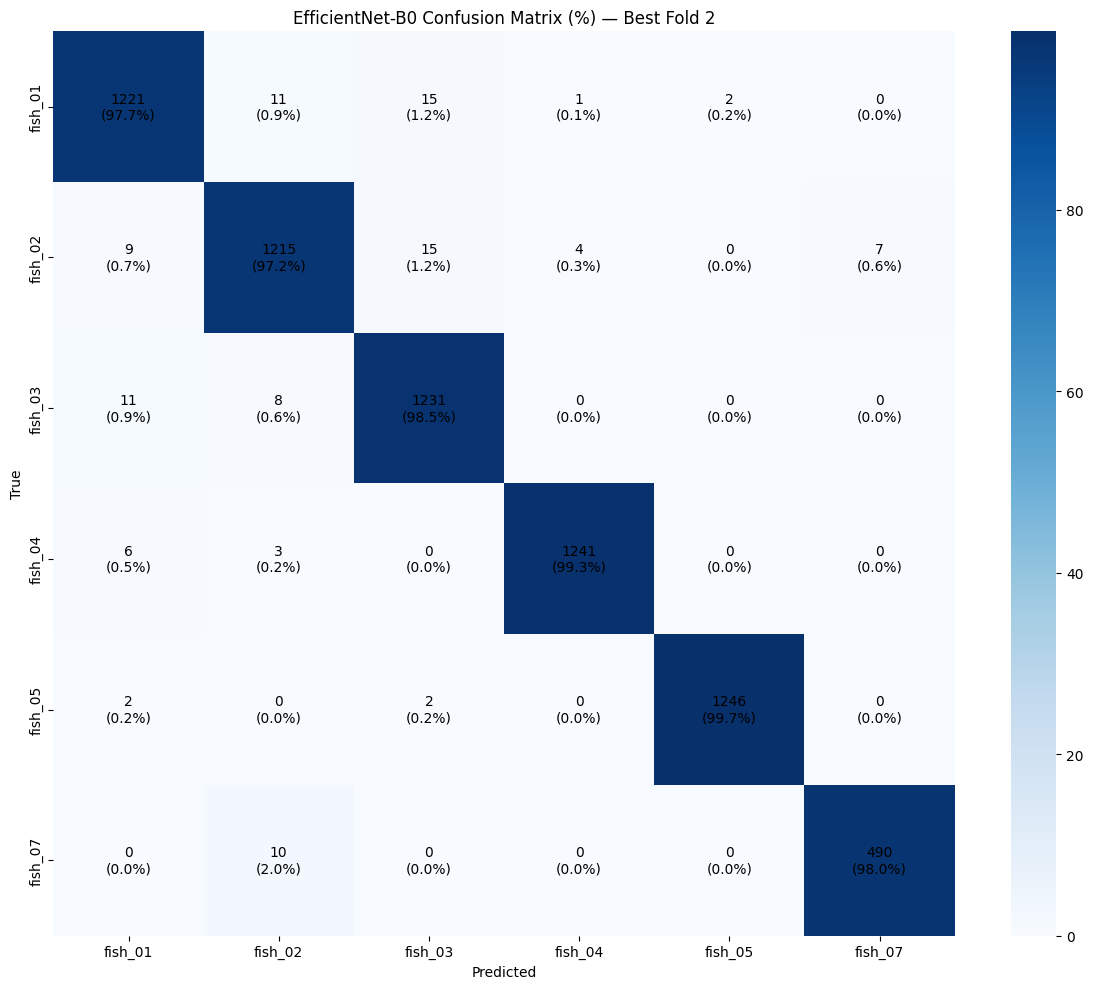


Classification Report:

              precision    recall  f1-score   support

     fish_01       0.98      0.98      0.98      1250
     fish_02       0.97      0.97      0.97      1250
     fish_03       0.97      0.98      0.98      1250
     fish_04       1.00      0.99      0.99      1250
     fish_05       1.00      1.00      1.00      1250
     fish_07       0.99      0.98      0.98       500

    accuracy                           0.98      6750
   macro avg       0.98      0.98      0.98      6750
weighted avg       0.98      0.98      0.98      6750



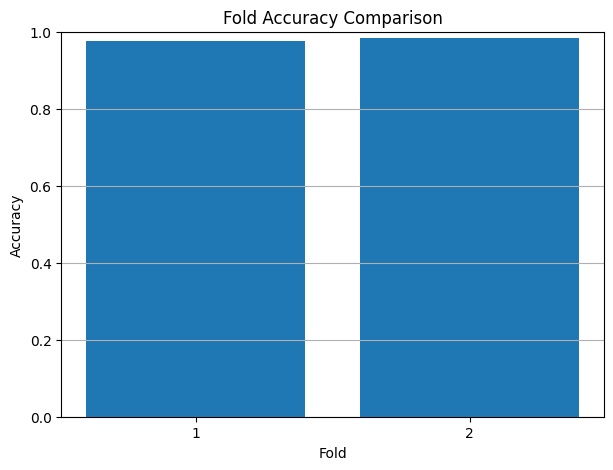

In [72]:
# ===============================================
# CELL 6 — EfficientNet-B0 Classification Evaluation
# ===============================================

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load best model
best_model = make_efficientnet()
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.to(device)
best_model.eval()

# Rebuild best validation set
best_split = list(skf.split(df["filepath"], df["class_id"]))[best_fold - 1]
val_idx_best = best_split[1]
val_df_best = df.iloc[val_idx_best].reset_index(drop=True)

val_ds_best = FishClassificationDataset(val_df_best, val_transform)
val_loader_best = DataLoader(val_ds_best, batch_size=32, shuffle=False, num_workers=2)

all_preds = []
all_true = []

with torch.no_grad():
    for imgs, labels in val_loader_best:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = best_model(imgs)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_true, all_preds)
cm_percent = (cm / cm.sum(axis=1, keepdims=True)) * 100

classes = list(idx_to_class.values())

plt.figure(figsize=(12, 10))
ax = sns.heatmap(cm_percent, annot=False, cmap="Blues",
                 xticklabels=classes, yticklabels=classes)

# Add counts + percentage inside each square
for i in range(len(classes)):
    for j in range(len(classes)):
        count = cm[i, j]
        pct = cm_percent[i, j]
        text = f"{count}\n({pct:.1f}%)"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center', color="black", fontsize=10)

plt.title(f"EfficientNet-B0 Confusion Matrix (%) — Best Fold {best_fold}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_true, all_preds, target_names=classes))

# Fold Accuracy Bar Plot
plt.figure(figsize=(7,5))
plt.bar(range(1, len(fold_accuracies)+1), fold_accuracies)
plt.xticks(range(1, len(fold_accuracies)+1))
plt.ylim(0.0, 1.0)
plt.title("Fold Accuracy Comparison")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()


In [38]:
import os

fish_image_dir = "/content/fish_dataset/fish_image"
mask_image_dir = "/content/fish_dataset/mask_image"

fish_classes = sorted(os.listdir(fish_image_dir))

pairs = []

for fish_cls in fish_classes:
    fish_folder = os.path.join(fish_image_dir, fish_cls)
    mask_folder = os.path.join(mask_image_dir, fish_cls)

    fish_files = sorted([f for f in os.listdir(fish_folder) if f.lower().endswith(".png")])

    for f in fish_files:
        mask_name = f.replace("fish_", "mask_")
        mask_path = os.path.join(mask_folder, mask_name)

        if os.path.exists(mask_path):
            pairs.append((img_path := os.path.join(fish_folder, f),
                          mask_path))

print("Total matched pairs:", len(pairs))


Total matched pairs: 14899


In [43]:
import os
import pandas as pd

# Dataset folders
fish_image_dir = "/content/fish_dataset/fish_image"
mask_image_dir = "/content/fish_dataset/mask_image"

# Keep only these 6 classes
valid_classes = ["fish_01", "fish_02", "fish_03", "fish_04", "fish_05", "fish_07"]

pairs = []

for fish_cls in valid_classes:
    fish_folder = os.path.join(fish_image_dir, fish_cls)
    mask_folder = os.path.join(mask_image_dir, fish_cls)

    if not os.path.exists(fish_folder) or not os.path.exists(mask_folder):
        continue

    fish_files = sorted([f for f in os.listdir(fish_folder) if f.lower().endswith(".png")])

    for f in fish_files:
        mask_name = f.replace("fish_", "mask_")
        mask_path = os.path.join(mask_folder, mask_name)

        if os.path.exists(mask_path):
            img_path = os.path.join(fish_folder, f)
            pairs.append((img_path, mask_path, fish_cls))

# Build DataFrame
seg_df = pd.DataFrame(pairs, columns=["image_path", "mask_path", "class"])
seg_df["class_id"] = seg_df["class"].astype("category").cat.codes

seg_class_to_idx = dict(zip(seg_df["class"].unique(), seg_df["class_id"].unique()))
seg_idx_to_class = {v: k for k, v in seg_class_to_idx.items()}

print("Segmentation Samples:", len(seg_df))
print("Segmentation Classes:", seg_idx_to_class)
print(seg_df.head())


Segmentation Samples: 12950
Segmentation Classes: {np.int8(0): 'fish_01', np.int8(1): 'fish_02', np.int8(2): 'fish_03', np.int8(3): 'fish_04', np.int8(4): 'fish_05', np.int8(5): 'fish_07'}
                                          image_path  \
0  /content/fish_dataset/fish_image/fish_01/fish_...   
1  /content/fish_dataset/fish_image/fish_01/fish_...   
2  /content/fish_dataset/fish_image/fish_01/fish_...   
3  /content/fish_dataset/fish_image/fish_01/fish_...   
4  /content/fish_dataset/fish_image/fish_01/fish_...   

                                           mask_path    class  class_id  
0  /content/fish_dataset/mask_image/fish_01/mask_...  fish_01         0  
1  /content/fish_dataset/mask_image/fish_01/mask_...  fish_01         0  
2  /content/fish_dataset/mask_image/fish_01/mask_...  fish_01         0  
3  /content/fish_dataset/mask_image/fish_01/mask_...  fish_01         0  
4  /content/fish_dataset/mask_image/fish_01/mask_...  fish_01         0  


In [44]:
import shutil
from sklearn.model_selection import train_test_split

print("Original class distribution:")
print(seg_df["class_id"].value_counts())

train_df, val_df = train_test_split(
    seg_df, test_size=0.2, random_state=42,
    stratify=seg_df["class_id"]
)

print("\nTrain class distribution:")
print(train_df["class_id"].value_counts())
print("\nVal class distribution:")
print(val_df["class_id"].value_counts())

yolo_root = "/content/yolo_fish_seg"
if os.path.exists(yolo_root):
    shutil.rmtree(yolo_root)

for split in ["train", "val"]:
    os.makedirs(os.path.join(yolo_root, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(yolo_root, split, "masks"), exist_ok=True)

def copy_data(df_subset, split):
    for _, row in df_subset.iterrows():
        shutil.copy(row["image_path"], os.path.join(yolo_root, split, "images", os.path.basename(row["image_path"])))
        shutil.copy(row["mask_path"], os.path.join(yolo_root, split, "masks", os.path.basename(row["mask_path"])))

copy_data(train_df, "train")
copy_data(val_df, "val")

print("\nYOLO segmentation dataset ready at:", yolo_root)


Original class distribution:
class_id
0    2500
1    2500
2    2500
3    2500
4    2500
5     450
Name: count, dtype: int64

Train class distribution:
class_id
2    2000
1    2000
0    2000
4    2000
3    2000
5     360
Name: count, dtype: int64

Val class distribution:
class_id
3    500
4    500
2    500
0    500
1    500
5     90
Name: count, dtype: int64

YOLO segmentation dataset ready at: /content/yolo_fish_seg


In [45]:
# Force YOLO to rebuild label cache
!rm -f /content/yolo_fish_binary/train/labels.cache
!rm -f /content/yolo_fish_binary/val/labels.cache

print("🔄 Label cache cleared!")


🔄 Label cache cleared!


In [49]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Remove ANY incorrect labels first
for split in ["train", "val"]:
    label_dir = os.path.join(yolo_root, split, "labels")
    if os.path.exists(label_dir):
        shutil.rmtree(label_dir)
    os.makedirs(label_dir, exist_ok=True)


def create_yolo_labels(df, split):
    label_dir = os.path.join(yolo_root, split, "labels")
    mask_dir = os.path.join(yolo_root, split, "masks")

    print(f"Generating labels for {split}...")

    for _, row in tqdm(df.iterrows(), total=len(df)):
        mask_path = row["mask_path"]
        class_id = row["class_id"]

        img_name = os.path.basename(row["image_path"])
        label_path = os.path.join(label_dir, img_name.replace(".png", ".txt"))

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue

        _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        with open(label_path, "w") as f:
            for cnt in contours:
                if cv2.contourArea(cnt) < 50:
                    continue

                h, w = mask_bin.shape
                poly = cnt.reshape(-1, 2)
                poly_norm = [(x/w, y/h) for x, y in poly]
                flat = " ".join(map(str, np.array(poly_norm).flatten()))

                f.write(f"{class_id} {flat}\n")


create_yolo_labels(train_df, "train")
create_yolo_labels(val_df, "val")

print("✔ YOLO segmentation labels fixed!")


Generating labels for train...


100%|██████████| 10360/10360 [00:09<00:00, 1105.08it/s]


Generating labels for val...


100%|██████████| 2590/2590 [00:01<00:00, 1613.71it/s]

✔ YOLO segmentation labels fixed!


In [51]:
yaml_path = f"{yolo_root}/data.yaml"

with open(yaml_path, "w") as f:
    f.write(f"path: {yolo_root}\n")
    f.write("train: train/images\n")
    f.write("val: val/images\n")
    f.write("names:\n")
    for class_id, class_name in seg_idx_to_class.items():
        f.write(f"  {class_id}: {class_name}\n")

print("data.yaml saved at:", yaml_path)
!cat {yaml_path}


data.yaml saved at: /content/yolo_fish_seg/data.yaml
path: /content/yolo_fish_seg
train: train/images
val: val/images
names:
  0: fish_01
  1: fish_02
  2: fish_03
  3: fish_04
  4: fish_05
  5: fish_07


In [52]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

history = model.train(
    data=yaml_path,
    epochs=10,
    imgsz=128,
    batch=16,
    device=0,
    project="/content/runs/segment",
    name="multi_yolo_6cls",
    verbose=True
)

print("Training complete!")


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_fish_seg/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=128, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=multi_yolo_6cls2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

train: Scanning /content/yolo_fish_seg/train/labels... 10360 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10360/10360 1.6Kit/s 6.3s
train: New cache created: /content/yolo_fish_seg/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 271.9±383.0 MB/s, size: 18.4 KB)
val: Scanning /content/yolo_fish_seg/val/labels... 2590 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2590/2590 1.1Kit/s 2.4s
val: New cache created: /content/yolo_fish_seg/val/labels.cache
Plotting labels to /content/runs/segment/multi_yolo_6cls2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 66 weight(decay

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
/usr/local/lib/python3.12/dist-packages/torch/functional.py:373: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this op

       1/10     0.453G      1.052      1.648      1.432      1.046          8        128: 100% ━━━━━━━━━━━━ 648/648 5.7it/s 1:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 1% ──────────── 1/81 1.2it/s 0.2s<1:05

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 3.9it/s 20.9s
                   all       2590       2590      0.923      0.934      0.976      0.746      0.922      0.934      0.976      0.676

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       2/10     0.453G      0.877      1.419     0.6695      1.041         16        128: 0% ──────────── 0/648  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
/usr/local/lib/python3.12/dist-packages/torch/functional.py:373: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this op

       2/10     0.453G     0.8949      1.449     0.6829     0.9854          8        128: 100% ━━━━━━━━━━━━ 648/648 6.5it/s 1:39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 1% ──────────── 1/81 1.3it/s 0.2s<1:03

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 4.2it/s 19.5s
                   all       2590       2590      0.962       0.96      0.993      0.765      0.962       0.96      0.993      0.715

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       3/10     0.453G     0.8067      1.153     0.6538     0.9158         16        128: 0% ──────────── 0/648  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
/usr/local/lib/python3.12/dist-packages/torch/functional.py:373: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this op

       3/10     0.453G     0.8423      1.401       0.59     0.9641          8        128: 100% ━━━━━━━━━━━━ 648/648 6.8it/s 1:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 1% ──────────── 1/81 1.0s/it 0.3s<1:21

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 4.1it/s 19.6s
                   all       2590       2590      0.985      0.987      0.993      0.763      0.984      0.986      0.993      0.707

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       4/10     0.453G     0.7558       1.33     0.4752     0.9426         16        128: 0% ──────────── 0/648  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
/usr/local/lib/python3.12/dist-packages/torch/functional.py:373: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this op

       4/10     0.453G     0.7953      1.353     0.5168     0.9509          8        128: 100% ━━━━━━━━━━━━ 648/648 6.8it/s 1:35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 1% ──────────── 1/81 1.4it/s 0.2s<57.4s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 4.2it/s 19.1s
                   all       2590       2590      0.983      0.966      0.989      0.768      0.982      0.966      0.989      0.708

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       5/10     0.453G     0.7934      1.508     0.4496     0.9515         16        128: 0% ──────────── 0/648  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
/usr/local/lib/python3.12/dist-packages/torch/functional.py:373: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this op

       5/10     0.453G     0.7471      1.322     0.4625     0.9328          8        128: 100% ━━━━━━━━━━━━ 648/648 6.8it/s 1:35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 1% ──────────── 1/81 1.2s/it 0.4s<1:35

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 4.2it/s 19.5s
                   all       2590       2590      0.991      0.987      0.995      0.809      0.991      0.987      0.993      0.753

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       6/10     0.453G     0.8818      1.359      0.434     0.9787         16        128: 0% ──────────── 1/648 2.4it/s 0.2s<4:29

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
/usr/local/lib/python3.12/dist-packages/torch/functional.py:373: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this op

       6/10     0.453G     0.7096      1.279     0.4218     0.9169          8        128: 100% ━━━━━━━━━━━━ 648/648 6.9it/s 1:34
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 1% ──────────── 1/81 1.4it/s 0.2s<59.0s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 4.3it/s 18.7s
                   all       2590       2590      0.996      0.994      0.994      0.832      0.996      0.994      0.994      0.748

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       7/10     0.453G     0.6414      1.096     0.4151     0.8425         16        128: 0% ──────────── 0/648  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
/usr/local/lib/python3.12/dist-packages/torch/functional.py:373: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this op

       7/10     0.453G     0.6753      1.252     0.3872     0.9079          8        128: 100% ━━━━━━━━━━━━ 648/648 6.9it/s 1:33
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 1% ──────────── 1/81 1.4it/s 0.2s<56.7s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 4.1it/s 19.9s
                   all       2590       2590      0.994      0.998      0.995      0.847      0.994      0.998      0.995      0.767

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       8/10     0.453G     0.7124       1.11     0.3713     0.9493         16        128: 0% ──────────── 1/648 2.4it/s 0.2s<4:25

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
/usr/local/lib/python3.12/dist-packages/torch/functional.py:373: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this op

       8/10     0.453G     0.6467      1.225     0.3661     0.8972          8        128: 100% ━━━━━━━━━━━━ 648/648 6.9it/s 1:34
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 1% ──────────── 1/81 1.3it/s 0.2s<1:02

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 4.3it/s 18.8s
                   all       2590       2590      0.998      0.997      0.995      0.848      0.998      0.997      0.995      0.766

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       9/10     0.453G     0.5077      1.037     0.3926     0.8303         16        128: 0% ──────────── 0/648  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
/usr/local/lib/python3.12/dist-packages/torch/functional.py:373: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this op

       9/10     0.453G     0.6201      1.195     0.3404     0.8892          8        128: 100% ━━━━━━━━━━━━ 648/648 6.9it/s 1:34
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 1% ──────────── 1/81 1.4it/s 0.2s<57.6s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 4.2it/s 19.3s
                   all       2590       2590      0.997      0.997      0.995       0.86      0.996      0.997      0.995      0.774

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      10/10     0.453G     0.6608      1.165     0.3534      0.894         16        128: 0% ──────────── 0/648  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
/usr/local/lib/python3.12/dist-packages/torch/functional.py:373: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this op

      10/10     0.453G     0.5993      1.179     0.3201     0.8835          8        128: 100% ━━━━━━━━━━━━ 648/648 7.0it/s 1:33
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 1% ──────────── 1/81 1.0it/s 0.3s<1:17

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 4.1it/s 19.9s
                   all       2590       2590      0.998      0.998      0.995       0.88      0.998      0.998      0.995      0.776

10 epochs completed in 0.324 hours.
Optimizer stripped from /content/runs/segment/multi_yolo_6cls2/weights/last.pt, 6.7MB
Optimizer stripped from /content/runs/segment/multi_yolo_6cls2/weights/best.pt, 6.7MB

Validating /content/runs/segment/multi_yolo_6cls2/weights/best.pt...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,259,234 parameters, 0 gradients, 11.3 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 4.6it/s 17.6s
                   all       2590       2590      0.998      0.998      0.

Evaluating: 100%|██████████| 20/20 [00:00<00:00, 28.70it/s]


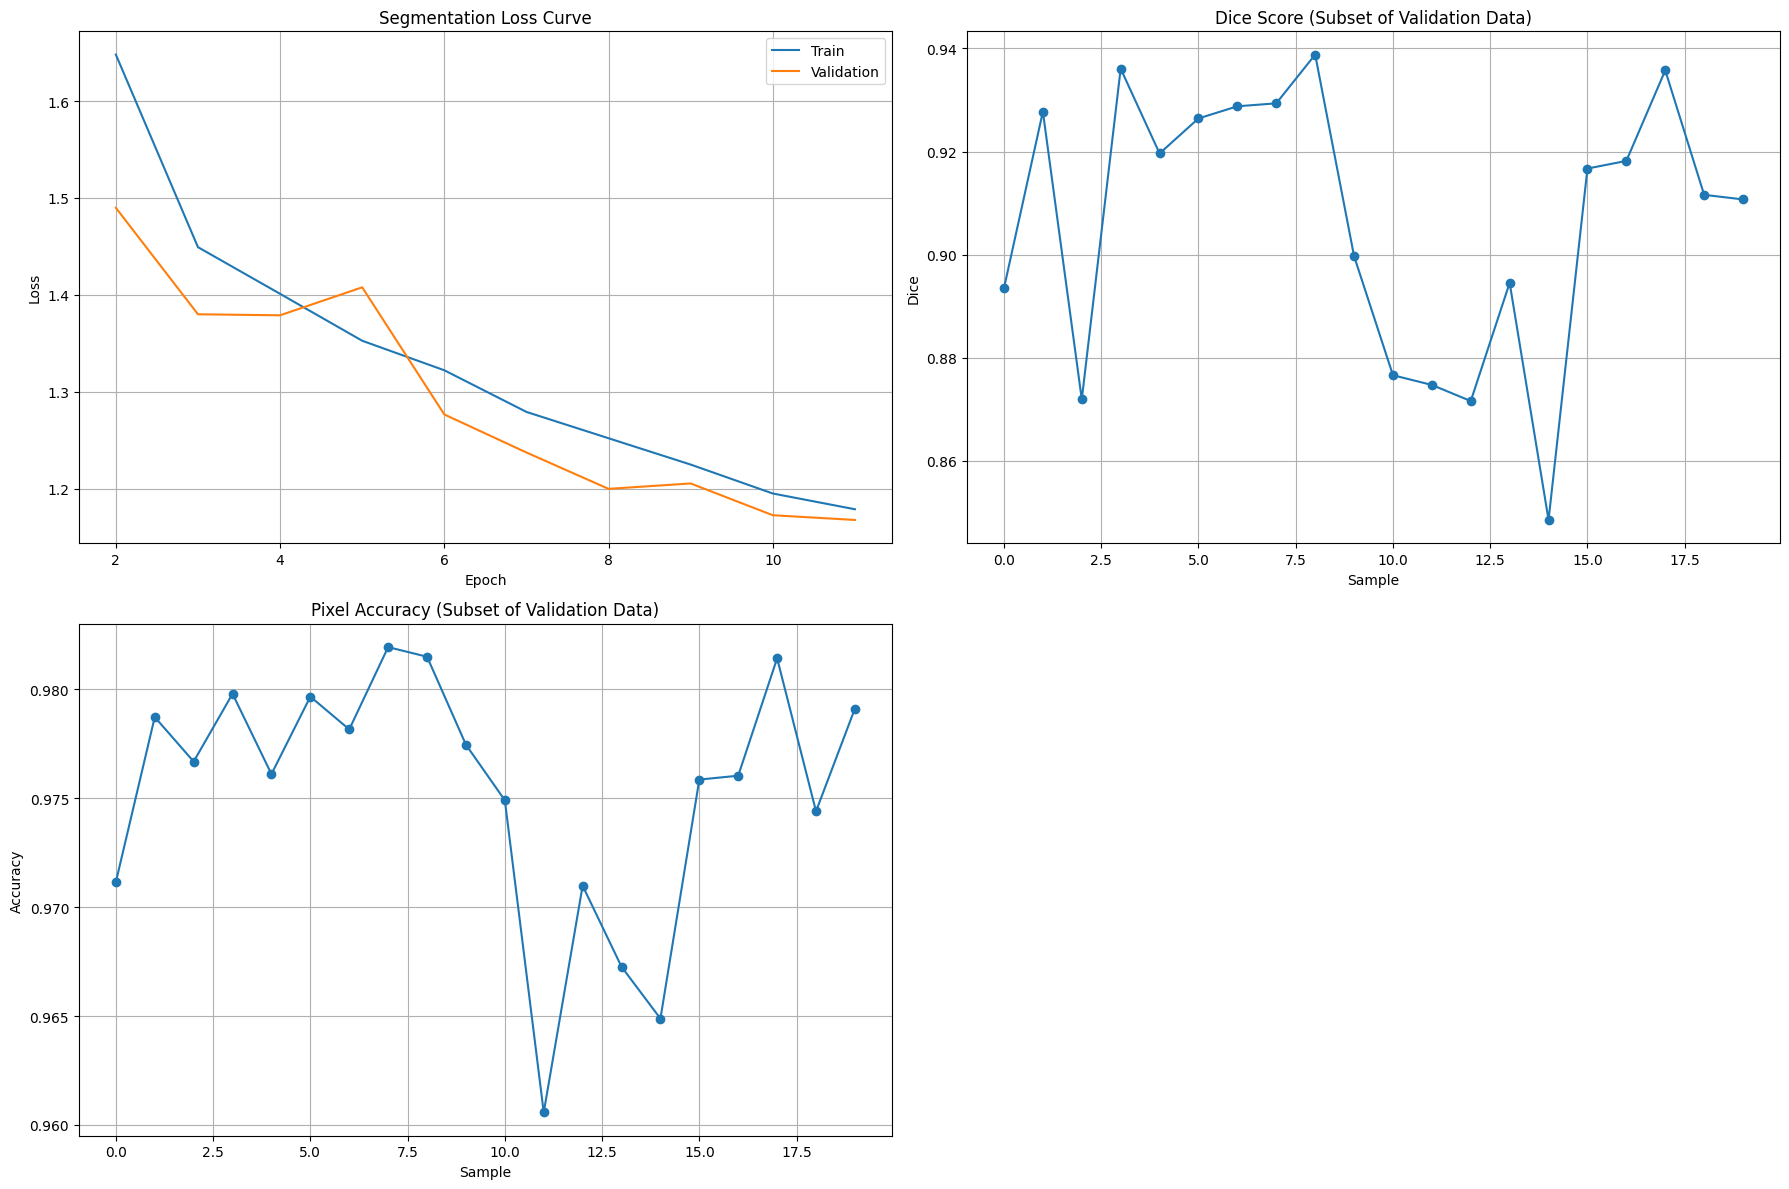

Evaluation completed.


In [54]:
# ===============================================
# YOLO Multi-Class Segmentation Evaluation Plots
# ===============================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
import cv2
import torch
from ultralytics import YOLO

# Load result logs from training run
results_csv = "/content/runs/segment/multi_yolo_6cls2/results.csv"
data = np.genfromtxt(results_csv, delimiter=',', names=True)

epochs = data['epoch'] + 1
train_loss = data['trainseg_loss']
val_loss = data['valseg_loss']

# Load trained segmentation model
model_path = "/content/runs/segment/multi_yolo_6cls2/weights/best.pt"
yolo_model = YOLO(model_path)

# Evaluate segmentation metrics on a small validation subset (for speed)
subset_size = 20
val_subset = val_df.iloc[:subset_size]

dice_scores = []
pixel_accuracies = []

def compute_dice(gt, pred):
    intersection = np.sum(gt * pred)
    union = np.sum(gt) + np.sum(pred)
    return (2 * intersection) / union if union != 0 else 1.0

for _, row in tqdm(val_subset.iterrows(), total=len(val_subset), desc="Evaluating"):
    img_path = row["image_path"]
    mask_path = row["mask_path"]

    img = cv2.imread(img_path)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = (gt_mask > 0).astype(np.uint8)

    # YOLO prediction
    results = yolo_model(img_path, verbose=False)[0]

    if results.masks is None:
        pred_mask = np.zeros_like(gt_mask)
    else:
        # Combine predicted instance masks into a single binary mask
        m = results.masks.data.cpu().numpy()
        combined = np.max(m, axis=0)
        pred_mask = (combined > 0.5).astype(np.uint8)

    # Resize predicted mask if needed
    pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]))

    # Metrics
    dice_scores.append(compute_dice(gt_mask, pred_mask))
    pixel_accuracies.append(accuracy_score(gt_mask.flatten(), pred_mask.flatten()))


# ===============================================
# Plot evaluation curves
# ===============================================
plt.figure(figsize=(18, 12))

# Training vs Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, val_loss, label="Validation")
plt.title("Segmentation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Dice Scores
plt.subplot(2, 2, 2)
plt.plot(dice_scores, marker='o')
plt.title("Dice Score (Subset of Validation Data)")
plt.xlabel("Sample")
plt.ylabel("Dice")
plt.grid(True)

# Pixel Accuracy
plt.subplot(2, 2, 3)
plt.plot(pixel_accuracies, marker='o')
plt.title("Pixel Accuracy (Subset of Validation Data)")
plt.xlabel("Sample")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

print("Evaluation completed.")


In [57]:
# Build pairs for Detectron2 (image, mask) from YOLO dataframe
train_pairs = list(zip(train_df["image_path"].tolist(), train_df["mask_path"].tolist()))
val_pairs   = list(zip(val_df["image_path"].tolist(), val_df["mask_path"].tolist()))

print("Train pairs:", len(train_pairs))
print("Val pairs:", len(val_pairs))


Train pairs: 10360
Val pairs: 2590


In [58]:
# ===============================================
# CELL M1 — Register 6-Class Fish Dataset (Mask R-CNN)
# ===============================================
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

import cv2
import numpy as np

# Class name mapping (only the 6 kept classes)
mask_classes = ["fish_01", "fish_02", "fish_03", "fish_04", "fish_05", "fish_07"]
class_to_id = {cls: i for i, cls in enumerate(mask_classes)}

def build_instances(pairs_subset):
    dataset_dicts = []
    for idx, (img_path, mask_path) in enumerate(pairs_subset):
        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w = img.shape[:2]

        # Load single-object binary mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(
            mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        fish_class = os.path.basename(os.path.dirname(img_path))
        if fish_class not in class_to_id:
            continue
        cat_id = class_to_id[fish_class]

        annos = []
        for cnt in contours:
            if cv2.contourArea(cnt) < 30:
                continue
            x, y, bw, bh = cv2.boundingRect(cnt)
            bbox = [x, y, x + bw, y + bh]
            poly = cnt.reshape(-1, 2).flatten().tolist()

            if len(poly) < 6:
                continue

            annos.append({
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": cat_id,
                "iscrowd": 0,
            })

        if len(annos) == 0:
            continue

        record = {
            "file_name": img_path,
            "image_id": idx,
            "height": h,
            "width": w,
            "annotations": annos,
        }

        dataset_dicts.append(record)

    return dataset_dicts


# Detectron2 dataset registration
def get_fish_seg_train():
    return build_instances(train_pairs)

def get_fish_seg_val():
    return build_instances(val_pairs)


DatasetCatalog.clear()
DatasetCatalog.register("fish_seg_train", get_fish_seg_train)
DatasetCatalog.register("fish_seg_val",   get_fish_seg_val)

MetadataCatalog.get("fish_seg_train").set(thing_classes=mask_classes)
MetadataCatalog.get("fish_seg_val").set(thing_classes=mask_classes)

print("Mask R-CNN segmentation dataset with 6 classes registered.")


Mask R-CNN segmentation dataset with 6 classes registered.


In [59]:
# ===============================================
# CELL M2 — Train Mask R-CNN (6-Class Segmentation)
# ===============================================
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")
)

cfg.DATASETS.TRAIN = ("fish_seg_train",)
cfg.DATASETS.TEST  = ("fish_seg_val",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"
)

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 4000  # increase if training underfits
cfg.SOLVER.STEPS = []
cfg.SOLVER.WARMUP_ITERS = 0

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # six fish species

cfg.MODEL.DEVICE = "cuda"

cfg.OUTPUT_DIR = "/content/maskrcnn_fish6"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

print(cfg)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

print("Mask R-CNN 6-class training completed.")


CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('fish_seg_val',)
  TRAIN: ('fish_seg_train',)
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUS

model_final_a54504.pkl: 178MB [00:00, 210MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/09 19:31:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
W1209 19:31:23.670000 804 torch/fx/_symbolic_trace.py:52] is_fx_tracing will return true for both fx.symbolic_trace and torch.export. Please use is_fx_tracing_symbolic_tracing() for specifically fx.symbolic_trace or torch.compiler.is_compiling() for specifically torch.export/compile.


[12/09 19:31:31 d2.utils.events]:  eta: 0:25:22  iter: 19  total_loss: 2.48  loss_cls: 1.09  loss_box_reg: 0.6393  loss_mask: 0.6786  loss_rpn_cls: 0.01085  loss_rpn_loc: 0.008605    time: 0.3850  last_time: 0.4379  data_time: 0.0172  last_data_time: 0.0099   lr: 0.00025  max_mem: 2678M
[12/09 19:31:40 d2.utils.events]:  eta: 0:26:42  iter: 39  total_loss: 1.87  loss_cls: 0.5178  loss_box_reg: 0.6574  loss_mask: 0.6145  loss_rpn_cls: 0.005882  loss_rpn_loc: 0.006417    time: 0.4191  last_time: 0.3182  data_time: 0.0072  last_data_time: 0.0032   lr: 0.00025  max_mem: 2678M
[12/09 19:31:48 d2.utils.events]:  eta: 0:25:37  iter: 59  total_loss: 1.622  loss_cls: 0.4384  loss_box_reg: 0.6493  loss_mask: 0.5312  loss_rpn_cls: 0.003326  loss_rpn_loc: 0.004687    time: 0.4054  last_time: 0.3559  data_time: 0.0079  last_data_time: 0.0075   lr: 0.00025  max_mem: 2678M
[12/09 19:31:56 d2.utils.events]:  eta: 0:25:28  iter: 79  total_loss: 1.57  loss_cls: 0.4503  loss_box_reg: 0.6883  loss_mask: 0

[12/09 19:57:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/maskrcnn_fish6/model_final.pth ...


Evaluating Mask R-CNN: 100%|██████████| 30/30 [00:03<00:00,  9.61it/s]


===== Mask R-CNN Evaluation Results =====
Samples Evaluated     : 30
Mean Dice Score       : 0.8947
Mean Pixel Accuracy   : 0.9675
Precision             : 0.8316
Recall                : 0.9304
Pixel Accuracy (CM)   : 0.9662
-----------------------------------------


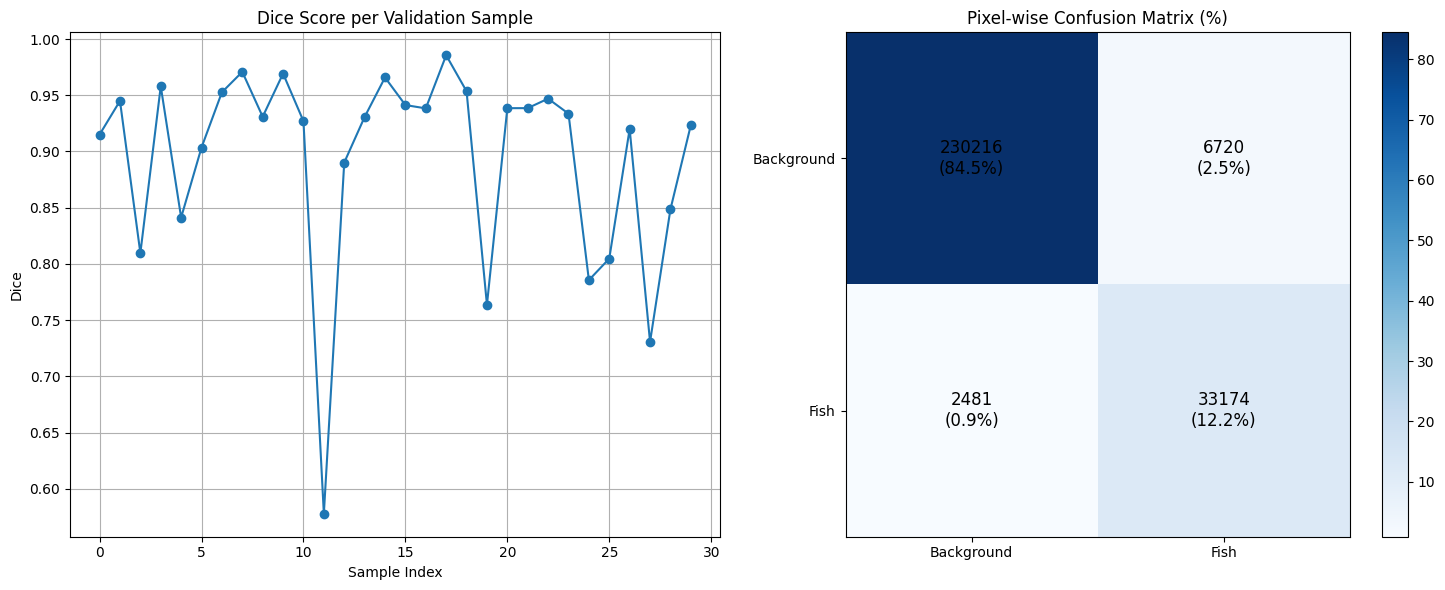

In [60]:
# ===============================================
# CELL M3 — Evaluate Mask R-CNN Binary Segmentation
# ===============================================
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from detectron2.engine import DefaultPredictor
import os

# Clone config and load trained weights
cfg_eval = cfg.clone()
cfg_eval.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg_eval.MODEL.DEVICE = "cuda"
predictor = DefaultPredictor(cfg_eval)

# Use subset for evaluation
N_SAMPLES = 30
eval_subset = val_pairs[:N_SAMPLES]

dice_scores = []
pixel_accs = []
y_true_pix = []
y_pred_pix = []

def dice_coefficient(gt, pred):
    intersection = np.logical_and(gt, pred).sum()
    return (2 * intersection) / (gt.sum() + pred.sum() + 1e-7)

for img_path, mask_path in tqdm(eval_subset, desc="Evaluating Mask R-CNN"):
    img = cv2.imread(img_path)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or gt_mask is None:
        continue

    gt_bin = (gt_mask > 127).astype(np.uint8)

    outputs = predictor(img)
    instances = outputs["instances"]

    if len(instances) > 0:
        pred_masks = instances.pred_masks.cpu().numpy()
        pred_bin = np.any(pred_masks, axis=0).astype(np.uint8)
    else:
        pred_bin = np.zeros_like(gt_bin, dtype=np.uint8)

    # Fix any shape mismatch
    if pred_bin.shape != gt_bin.shape:
        pred_bin = cv2.resize(pred_bin, (gt_bin.shape[1], gt_bin.shape[0]),
                              interpolation=cv2.INTER_NEAREST)

    dice = dice_coefficient(gt_bin, pred_bin)
    acc = (gt_bin == pred_bin).mean()

    dice_scores.append(dice)
    pixel_accs.append(acc)

    y_true_pix.extend(gt_bin.flatten())
    y_pred_pix.extend(pred_bin.flatten())

# Confusion Matrix
cm = confusion_matrix(y_true_pix, y_pred_pix)
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp + 1e-7)
recall = tp / (tp + fn + 1e-7)
pixel_acc = (tp + tn) / cm.sum()

print("===== Mask R-CNN Evaluation Results =====")
print(f"Samples Evaluated     : {len(dice_scores)}")
print(f"Mean Dice Score       : {np.mean(dice_scores):.4f}")
print(f"Mean Pixel Accuracy   : {np.mean(pixel_accs):.4f}")
print(f"Precision             : {precision:.4f}")
print(f"Recall                : {recall:.4f}")
print(f"Pixel Accuracy (CM)   : {pixel_acc:.4f}")
print("-----------------------------------------")

#===========================================
# Plots
#===========================================
plt.figure(figsize=(15, 6))

# Dice scores plot
plt.subplot(1, 2, 1)
plt.plot(dice_scores, marker='o')
plt.title("Dice Score per Validation Sample")
plt.xlabel("Sample Index")
plt.ylabel("Dice")
plt.grid(True)

# Confusion matrix plot
plt.subplot(1, 2, 2)
cm_percent = (cm / cm.sum()) * 100
plt.imshow(cm_percent, cmap="Blues")
plt.title("Pixel-wise Confusion Matrix (%)")
plt.xticks([0, 1], ["Background", "Fish"])
plt.yticks([0, 1], ["Background", "Fish"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm[i,j]}\n({cm_percent[i,j]:.1f}%)",
                 ha='center', va='center', color="black", fontsize=12)
plt.colorbar()
plt.tight_layout()
plt.show()


In [61]:
# ===============================================
# CELL S1 — Image & Mask Transforms for SegNet
# ===============================================
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from PIL import Image
import torch

IMG_SIZE = 224

# Image Transform (Normalize for CNN)
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # 0–1 float
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Mask Transform (No normalization, keep class IDs)
def mask_transform(mask):
    mask = Image.fromarray(mask)
    mask = mask.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
    mask = torch.from_numpy(np.array(mask)).long()
    return mask


In [62]:
# ===============================================
# CELL S2 — SegNet Dataset & DataLoaders (6 classes)
# ===============================================
import torch
import torch.nn as nn
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

IMG_SIZE = 224

# Six classes: fish_01, fish_02, fish_03, fish_04, fish_05, fish_07, background=0
class_map = {
    0: 1,
    1: 2,
    2: 3,
    3: 4,
    4: 5,
    5: 6
}

class SegNetDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path, class_id = self.pairs[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = TF.to_tensor(img)  # 0–1 float
        img = TF.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        # Convert 255 → class index
        mask = (mask > 127).astype(np.uint8) * class_map[class_id]
        mask = torch.tensor(mask).long()

        return img, mask


train_dataset_seg = SegNetDataset(train_pairs)
val_dataset_seg   = SegNetDataset(val_pairs)

train_loader = DataLoader(train_dataset_seg, batch_size=6, shuffle=True)
val_loader   = DataLoader(val_dataset_seg, batch_size=6, shuffle=False)

print("SegNet datasets ready")
print(f"Train samples: {len(train_dataset_seg)} | Val samples: {len(val_dataset_seg)}")


Using: cuda
SegNet datasets ready
Train samples: 10360 | Val samples: 2590


In [63]:
# ===============================================
# CELL S3 — SegNet Model (7-Class + BatchNorm)
# ===============================================
import torch
import torch.nn as nn
import torch.nn.functional as F

NUM_CLASSES = 7  # background + 6 fish classes

class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=NUM_CLASSES):
        super(SegNet, self).__init__()

        # Encoder blocks
        self.enc1 = self._block(in_channels, 64)
        self.enc2 = self._block(64, 128)
        self.enc3 = self._block(128, 256)
        self.enc4 = self._block(256, 512)
        self.enc5 = self._block(512, 512)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)

        # Decoder blocks (mirrored)
        self.dec5 = self._block(512, 512)
        self.dec4 = self._block(512, 256)
        self.dec3 = self._block(256, 128)
        self.dec2 = self._block(128, 64)
        self.dec1 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

    def _block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x, idx1 = self.pool(self.enc1(x))
        x, idx2 = self.pool(self.enc2(x))
        x, idx3 = self.pool(self.enc3(x))
        x, idx4 = self.pool(self.enc4(x))
        x, idx5 = self.pool(self.enc5(x))

        x = self.unpool(x, idx5)
        x = self.dec5(x)
        x = self.unpool(x, idx4)
        x = self.dec4(x)
        x = self.unpool(x, idx3)
        x = self.dec3(x)
        x = self.unpool(x, idx2)
        x = self.dec2(x)
        x = self.unpool(x, idx1)
        x = self.dec1(x)

        return x

model = SegNet().to(device)

# Multi-class segmentation loss
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("SegNet model ready.")


SegNet model ready.


Using: cuda

Training SegNet...



Train 1/10: 100%|██████████| 1295/1295 [01:28<00:00, 14.55it/s]


Epoch 1: Train Loss: 0.2351 | Val Loss: 0.1765 | Train Dice: 0.4916 | Val Dice: 0.7238


Train 2/10: 100%|██████████| 1295/1295 [01:29<00:00, 14.53it/s]


Epoch 2: Train Loss: 0.1698 | Val Loss: 0.1603 | Train Dice: 0.7172 | Val Dice: 0.7440


Train 3/10: 100%|██████████| 1295/1295 [01:27<00:00, 14.73it/s]


Epoch 3: Train Loss: 0.1553 | Val Loss: 0.1451 | Train Dice: 0.7472 | Val Dice: 0.7670


Train 4/10: 100%|██████████| 1295/1295 [01:28<00:00, 14.66it/s]


Epoch 4: Train Loss: 0.1447 | Val Loss: 0.1370 | Train Dice: 0.7680 | Val Dice: 0.7767


Train 5/10: 100%|██████████| 1295/1295 [01:27<00:00, 14.75it/s]


Epoch 5: Train Loss: 0.1385 | Val Loss: 0.1330 | Train Dice: 0.7791 | Val Dice: 0.7959


Train 6/10: 100%|██████████| 1295/1295 [01:27<00:00, 14.72it/s]


Epoch 6: Train Loss: 0.1339 | Val Loss: 0.1331 | Train Dice: 0.7876 | Val Dice: 0.7732


Train 7/10: 100%|██████████| 1295/1295 [01:27<00:00, 14.80it/s]


Epoch 7: Train Loss: 0.1307 | Val Loss: 0.1273 | Train Dice: 0.7932 | Val Dice: 0.8044


Train 8/10: 100%|██████████| 1295/1295 [01:27<00:00, 14.75it/s]


Epoch 8: Train Loss: 0.1270 | Val Loss: 0.1258 | Train Dice: 0.7999 | Val Dice: 0.8049


Train 9/10: 100%|██████████| 1295/1295 [01:27<00:00, 14.74it/s]


Epoch 9: Train Loss: 0.1247 | Val Loss: 0.1244 | Train Dice: 0.8041 | Val Dice: 0.8073


Train 10/10: 100%|██████████| 1295/1295 [01:27<00:00, 14.80it/s]


Epoch 10: Train Loss: 0.1228 | Val Loss: 0.1213 | Train Dice: 0.8072 | Val Dice: 0.8061


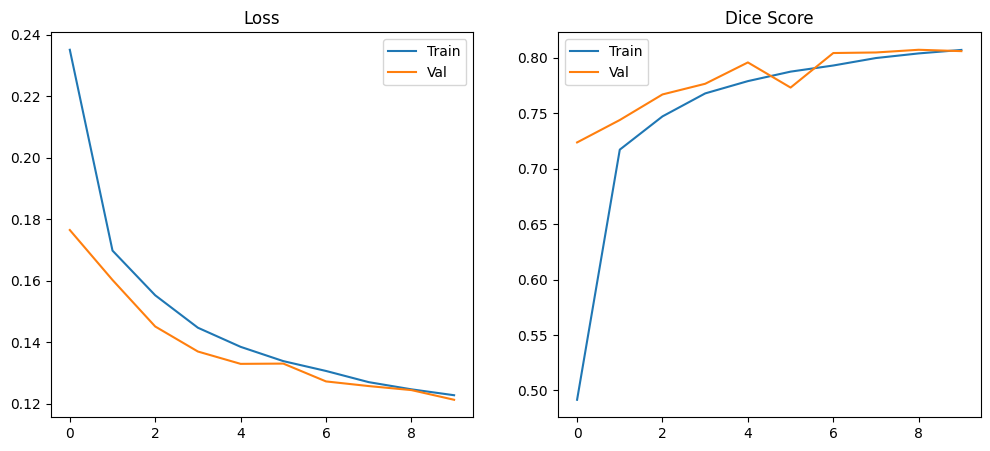

SegNet Training Completed


In [65]:
# ===============================================
# SegNet BINARY Segmentation - Training Cell
# ===============================================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

IMG_SIZE = 224

# Dataset
class FishSegDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
        self.tf_img = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
        ])
        self.tf_mask = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale binary mask

        img = self.tf_img(img)
        mask = self.tf_mask(mask)
        mask = (mask > 0.5).float()  # convert to binary tensor

        return img, mask


# Create Dataset + Dataloaders
train_ds = FishSegDataset(train_pairs)
val_ds   = FishSegDataset(val_pairs)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)


# SegNet Model
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # logits output


model = SegNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Metrics
def dice_coef(pred, target, eps=1e-7):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    return ((2*inter + eps) / (union + eps)).mean()

def pixel_acc(pred, target):
    pred = torch.sigmoid(pred)
    return ((pred > 0.5) == target.bool()).float().mean()


# Train
epochs = 10
train_loss_curve = []
val_loss_curve = []
train_dice_curve = []
val_dice_curve = []

print("\nTraining SegNet...\n")

for epoch in range(epochs):
    model.train()
    train_loss = train_d = 0

    for imgs, masks in tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_d += dice_coef(output, masks).item()

    train_loss /= len(train_loader)
    train_d /= len(train_loader)

    model.eval()
    val_loss = val_d = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            output = model(imgs)
            val_loss += criterion(output, masks).item()
            val_d += dice_coef(output, masks).item()

    val_loss /= len(val_loader)
    val_d /= len(val_loader)

    train_loss_curve.append(train_loss)
    val_loss_curve.append(val_loss)
    train_dice_curve.append(train_d)
    val_dice_curve.append(val_d)

    print(f"Epoch {epoch+1}: "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Dice: {train_d:.4f} | Val Dice: {val_d:.4f}")


# Plot curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(train_loss_curve, label="Train"); plt.plot(val_loss_curve, label="Val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(train_dice_curve, label="Train"); plt.plot(val_dice_curve, label="Val"); plt.title("Dice Score"); plt.legend()
plt.show()


print("SegNet Training Completed")


Evaluating SegNet: 100%|██████████| 30/30 [00:00<00:00, 94.57it/s] 



SegNet Performance on Validation Samples
Mean Dice Score     : 0.7620
Mean Pixel Accuracy : 0.9355
TN=1256576, FP=45906, FN=51251, TP=151547



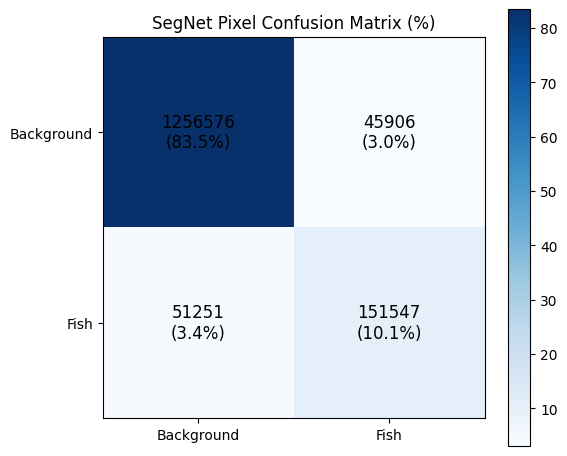

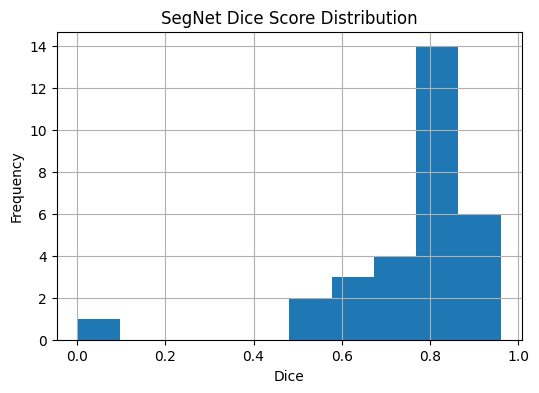

SegNet evaluation & plots completed.


In [67]:
# ===============================================
# SegNet Evaluation - Dice, Pixel Accuracy, Confusion Matrix
# ===============================================

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import cv2
from PIL import Image

model.eval()

dice_scores = []
pixel_accs = []
y_true_pix = []
y_pred_pix = []

# Evaluate on 30 validation samples (for speed)
N_SAMPLES = 30
val_subset = val_pairs[:N_SAMPLES]

def dice_coef_eval(pred, target, eps=1e-7):
    pred = (pred > 0.5).astype(np.uint8)
    inter = np.logical_and(pred, target).sum()
    union = pred.sum() + target.sum()
    return (2.0 * inter + eps) / (union + eps)


for img_path, mask_path in tqdm(val_subset, desc="Evaluating SegNet"):

    img = Image.open(img_path).convert("RGB")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img_tf = train_ds.tf_img(img).unsqueeze(0).to(device)
    gt_bin = (mask > 127).astype(np.uint8)

    # Predict
    with torch.no_grad():
        pred_logits = model(img_tf)
        pred_mask = torch.sigmoid(pred_logits)[0,0].cpu().numpy()
        pred_bin = (pred_mask > 0.5).astype(np.uint8)

    # Resize ground truth to match pred shape
    gt_resized = cv2.resize(gt_bin, (pred_bin.shape[1], pred_bin.shape[0]),
                            interpolation=cv2.INTER_NEAREST)

    # Metrics per-image
    dice_scores.append(dice_coef_eval(pred_bin, gt_resized))
    pixel_accs.append((pred_bin == gt_resized).mean())

    # Collect global pixel-wise labels for confusion matrix
    y_true_pix.extend(gt_resized.flatten())
    y_pred_pix.extend(pred_bin.flatten())


# Compute confusion matrix
cm = confusion_matrix(y_true_pix, y_pred_pix)
tn, fp, fn, tp = cm.ravel()
total = cm.sum()
cm_percent = cm / total * 100


# Print overall results
print("\nSegNet Performance on Validation Samples")
print(f"Mean Dice Score     : {np.mean(dice_scores):.4f}")
print(f"Mean Pixel Accuracy : {np.mean(pixel_accs):.4f}")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")


# =======================
# PLOTS
# =======================

plt.figure(figsize=(6,5))
plt.imshow(cm_percent, cmap="Blues")
plt.title("SegNet Pixel Confusion Matrix (%)")

classes = ["Background", "Fish"]
plt.xticks([0,1], classes)
plt.yticks([0,1], classes)

# Annotate with values and percent
for i in range(2):
    for j in range(2):
        plt.text(j, i,
                 f"{cm[i,j]}\n({cm_percent[i,j]:.1f}%)",
                 ha='center', va='center',
                 fontsize=12, color='black')

plt.colorbar()
plt.tight_layout()
plt.show()


# Histogram of Dice scores
plt.figure(figsize=(6,4))
plt.hist(dice_scores, bins=10)
plt.title("SegNet Dice Score Distribution")
plt.xlabel("Dice")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print("SegNet evaluation & plots completed.")
